# Olympic Games: 120 Years of Athletic Excellence & Medal Prediction

## Executive Summary

This comprehensive analysis explores **120 years of Olympic history** (1896-2016) and builds **machine learning models** to predict medal winners. We'll uncover fascinating insights about athletic performance, country dominance, and the evolution of the Games.

### Key Objectives:
- **Exploratory Data Analysis**: Discover patterns in Olympic participation and performance
- **Feature Engineering**: Create meaningful predictors from athlete characteristics
- **Machine Learning**: Build models to predict medal outcomes
- **Insights**: Extract actionable intelligence about athletic success

### What You'll Learn:
- Which countries dominate different sports?
- How have athlete characteristics evolved over time?
- Can we predict medal winners based on athlete profiles?
- What physical attributes lead to Olympic success?

# 1. Import Libraries & Load Data

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
df_events = pd.read_csv('/kaggle/input/120-years-of-olympic-history-athletes-and-results/athlete_events.csv')

In [3]:
df_noc = pd.read_csv('/kaggle/input/120-years-of-olympic-history-athletes-and-results/noc_regions.csv')

In [4]:
print(f"Events Dataset Shape: {df_events.shape}")
print(f"NOC Regions Dataset Shape: {df_noc.shape}")
print(f"\nTime Period: {df_events['Year'].min()} - {df_events['Year'].max()}")
print(f"Total Athletes: {df_events['ID'].nunique():,}")
print(f"Total Medal Entries: {df_events['Medal'].notna().sum():,}")

Events Dataset Shape: (271116, 15)
NOC Regions Dataset Shape: (230, 3)

Time Period: 1896 - 2016
Total Athletes: 135,571
Total Medal Entries: 39,783


# 2. Exploratory Data Analysis

In [5]:
# Quick overview of the datasets
print("ATHLETE EVENTS DATASET OVERVIEW")
print("=" * 50)
display(df_events.head())

print("\nDATA TYPES AND MISSING VALUES")
print("=" * 50)
info_df = pd.DataFrame({
    'Data Type': df_events.dtypes,
    'Missing Count': df_events.isnull().sum(),
    'Missing %': (df_events.isnull().sum() / len(df_events) * 100).round(2)
})
display(info_df[info_df['Missing Count'] > 0])

ATHLETE EVENTS DATASET OVERVIEW


ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's Football   NaN  
3       Tug-Of-War Men's Tug-Of-War  Gold  
4  Speed Skating Women's 500 metres   NaN


DATA TYPES AND MISSING VALUES


Data Type  Missing Count  Missing %
Age      float64           9474       3.49
Height   float64          60171      22.19
Weight   float64          62875      23.19
Medal     object         231333      85.33

## Key statistics about the dataset

In [6]:
print("KEY DATASET STATISTICS")
print("=" * 50)

total_athletes = df_events['ID'].nunique()
total_events = df_events['Event'].nunique()
total_sports = df_events['Sport'].nunique()
total_countries = df_events['NOC'].nunique()
total_olympics = df_events['Games'].nunique()

stats = {
    'Unique Athletes': f"{total_athletes:,}",
    'Unique Events': f"{total_events:,}",
    'Sports': f"{total_sports:,}",
    'Countries/Regions': f"{total_countries:,}",
    'Olympic Games': f"{total_olympics:,}",
    'Medal Awards': f"{df_events['Medal'].notna().sum():,}",
    'Medal Rate': f"{(df_events['Medal'].notna().sum() / len(df_events) * 100):.1f}%"
}

for key, value in stats.items():
    print(f"{key}: {value}")


KEY DATASET STATISTICS
Unique Athletes: 135,571
Unique Events: 765
Sports: 66
Countries/Regions: 230
Olympic Games: 51
Medal Awards: 39,783
Medal Rate: 14.7%


### Olympic Games Evolution Over Time

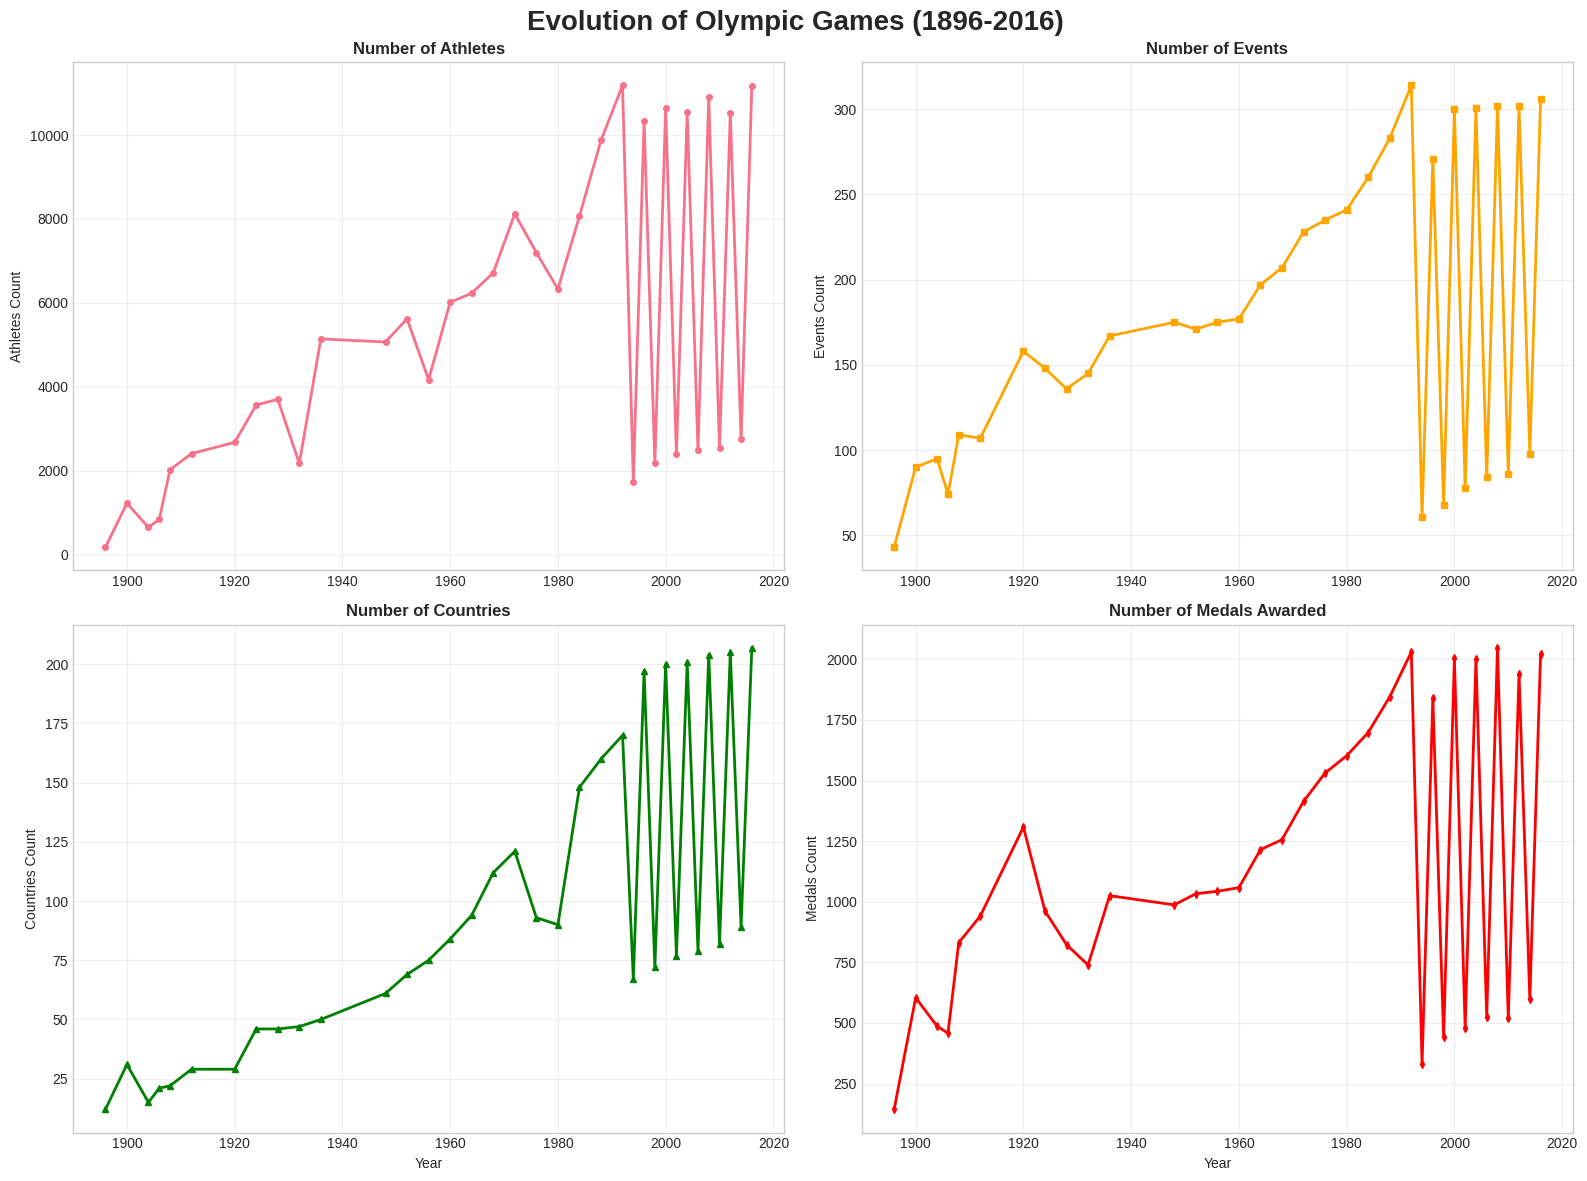


KEY INSIGHTS FROM EVOLUTION ANALYSIS:
Athletes increased from 176 to 11,183
Events grew from 43 to 314
Countries participation expanded from 12 to 207


In [7]:
# Evolution of Olympics over time
evolution_stats = df_events.groupby('Year').agg({
    'ID': 'nunique',  # Unique athletes
    'Event': 'nunique',  # Unique events
    'NOC': 'nunique',  # Unique countries
    'Medal': lambda x: x.notna().sum()  # Medal count
}).rename(columns={
    'ID': 'Athletes',
    'Event': 'Events',
    'NOC': 'Countries',
    'Medal': 'Medals'
})

# Create subplots for evolution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Evolution of Olympic Games (1896-2016)', fontsize=20, fontweight='bold')

# Athletes over time
axes[0,0].plot(evolution_stats.index, evolution_stats['Athletes'], marker='o', linewidth=2, markersize=4)
axes[0,0].set_title('Number of Athletes', fontweight='bold')
axes[0,0].set_ylabel('Athletes Count')
axes[0,0].grid(True, alpha=0.3)

# Events over time
axes[0,1].plot(evolution_stats.index, evolution_stats['Events'], marker='s', linewidth=2, markersize=4, color='orange')
axes[0,1].set_title('Number of Events', fontweight='bold')
axes[0,1].set_ylabel('Events Count')
axes[0,1].grid(True, alpha=0.3)

# Countries over time
axes[1,0].plot(evolution_stats.index, evolution_stats['Countries'], marker='^', linewidth=2, markersize=4, color='green')
axes[1,0].set_title('Number of Countries', fontweight='bold')
axes[1,0].set_ylabel('Countries Count')
axes[1,0].set_xlabel('Year')
axes[1,0].grid(True, alpha=0.3)

# Medals over time
axes[1,1].plot(evolution_stats.index, evolution_stats['Medals'], marker='d', linewidth=2, markersize=4, color='red')
axes[1,1].set_title('Number of Medals Awarded', fontweight='bold')
axes[1,1].set_ylabel('Medals Count')
axes[1,1].set_xlabel('Year')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\nKEY INSIGHTS FROM EVOLUTION ANALYSIS:")
print("=" * 60)
print(f"Athletes increased from {evolution_stats['Athletes'].min():,} to {evolution_stats['Athletes'].max():,}")
print(f"Events grew from {evolution_stats['Events'].min():,} to {evolution_stats['Events'].max():,}")
print(f"Countries participation expanded from {evolution_stats['Countries'].min():,} to {evolution_stats['Countries'].max():,}")

### Medal Distribution Analysis

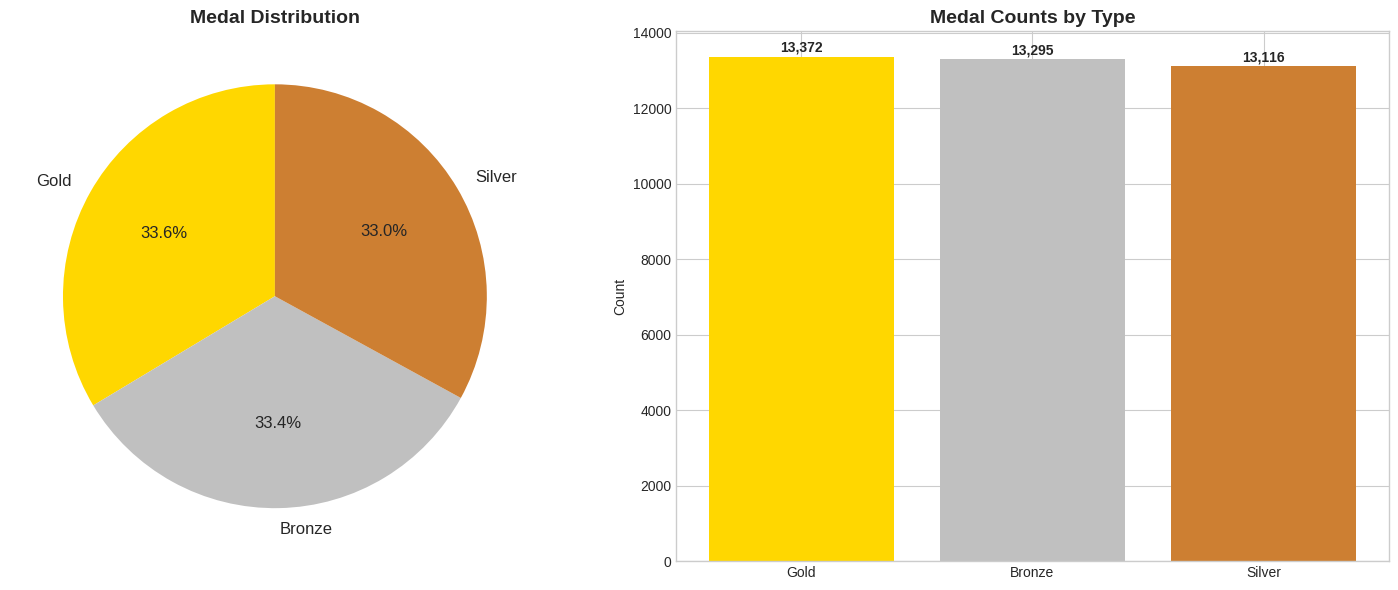


Total Medals Awarded: 39,783
Gold: 13,372 (33.6%)
Bronze: 13,295 (33.4%)
Silver: 13,116 (33.0%)


In [8]:
# Medal distribution analysis
medal_data = df_events[df_events['Medal'].notna()]

# Medal types distribution
medal_counts = medal_data['Medal'].value_counts()

# Create medal distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart for medal distribution
colors = ['#FFD700', '#C0C0C0', '#CD7F32']  # Gold, Silver, Bronze colors
axes[0].pie(medal_counts.values, labels=medal_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title('Medal Distribution', fontweight='bold', fontsize=14)

# Bar chart for medal counts
bars = axes[1].bar(medal_counts.index, medal_counts.values, color=colors)
axes[1].set_title('Medal Counts by Type', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Count')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal Medals Awarded: {medal_counts.sum():,}")
for medal, count in medal_counts.items():
    print(f"{medal}: {count:,} ({count/medal_counts.sum()*100:.1f}%)")

### Top Performing Countries

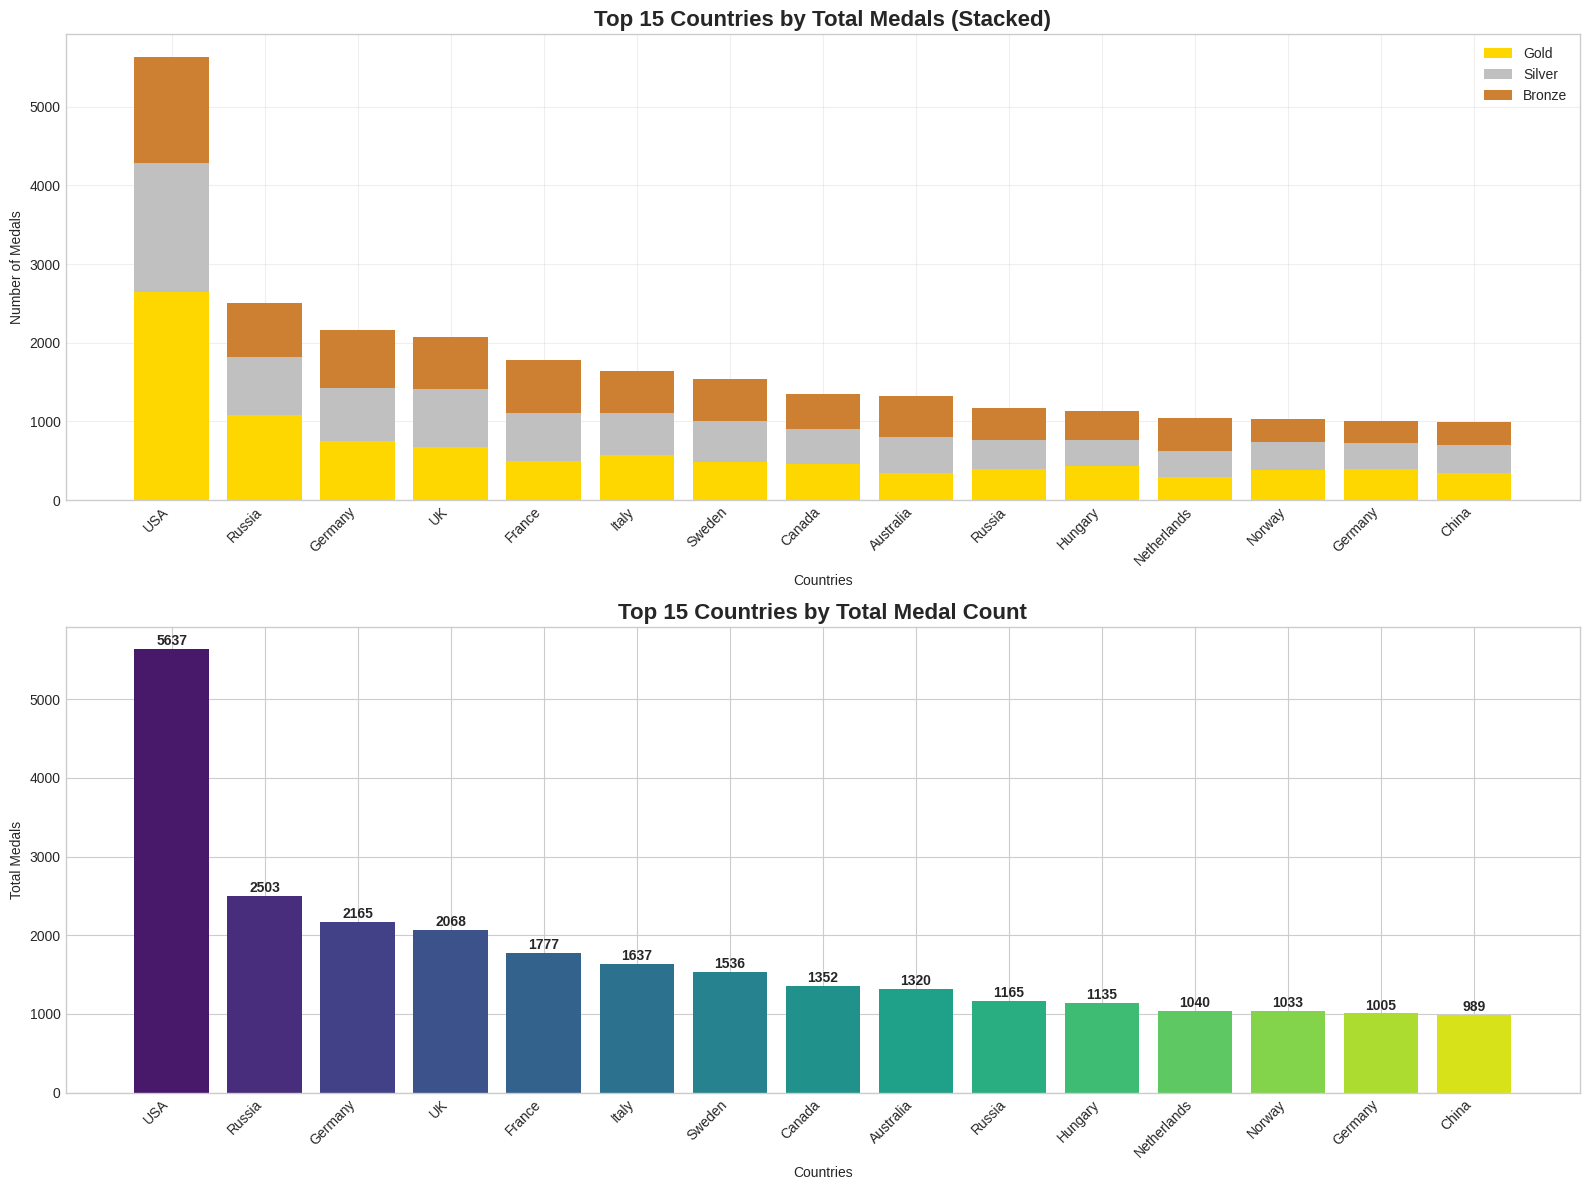


TOP 10 MEDAL-WINNING COUNTRIES:


Country  Gold  Silver  Bronze  Total
216.0        USA  2638    1641    1358   5637
214.0     Russia  1082     732     689   2503
79.0     Germany   745     674     746   2165
74.0          UK   678     739     651   2068
69.0      France   501     610     666   1777
100.0      Italy   575     531     531   1637
193.0     Sweden   479     522     535   1536
36.0      Canada   463     438     451   1352
12.0   Australia   348     455     517   1320
171.0     Russia   390     367     408   1165

In [9]:
# Top performing countries analysis
country_medals = df_events[df_events['Medal'].notna()].groupby(['NOC', 'Medal']).size().unstack(fill_value=0)
country_medals['Total'] = country_medals.sum(axis=1)
country_medals = country_medals.sort_values('Total', ascending=False)

# Merge with region names
country_medals_with_names = country_medals.merge(df_noc[['NOC', 'region']], 
                                                 left_index=True, right_on='NOC', how='left')
country_medals_with_names['Country'] = country_medals_with_names['region'].fillna(country_medals_with_names['NOC'])

# Top 15 countries
top_15_countries = country_medals_with_names.head(15)

# Create visualization for top countries
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Stacked bar chart for medal types
x_pos = np.arange(len(top_15_countries))
width = 0.8

p1 = axes[0].bar(x_pos, top_15_countries['Gold'], width, label='Gold', color='#FFD700')
p2 = axes[0].bar(x_pos, top_15_countries['Silver'], width, bottom=top_15_countries['Gold'], 
                label='Silver', color='#C0C0C0')
p3 = axes[0].bar(x_pos, top_15_countries['Bronze'], width, 
                bottom=top_15_countries['Gold'] + top_15_countries['Silver'], 
                label='Bronze', color='#CD7F32')

axes[0].set_title('Top 15 Countries by Total Medals (Stacked)', fontweight='bold', fontsize=16)
axes[0].set_xlabel('Countries')
axes[0].set_ylabel('Number of Medals')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(top_15_countries['Country'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Total medals bar chart
bars = axes[1].bar(range(len(top_15_countries)), top_15_countries['Total'], 
                   color=sns.color_palette("viridis", len(top_15_countries)))
axes[1].set_title('Top 15 Countries by Total Medal Count', fontweight='bold', fontsize=16)
axes[1].set_xlabel('Countries')
axes[1].set_ylabel('Total Medals')
axes[1].set_xticks(range(len(top_15_countries)))
axes[1].set_xticklabels(top_15_countries['Country'], rotation=45, ha='right')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Display top 10 countries table
print("\nTOP 10 MEDAL-WINNING COUNTRIES:")
print("=" * 70)
display(top_15_countries[['Country', 'Gold', 'Silver', 'Bronze', 'Total']].head(10))


### Athlete Demographics Analysis

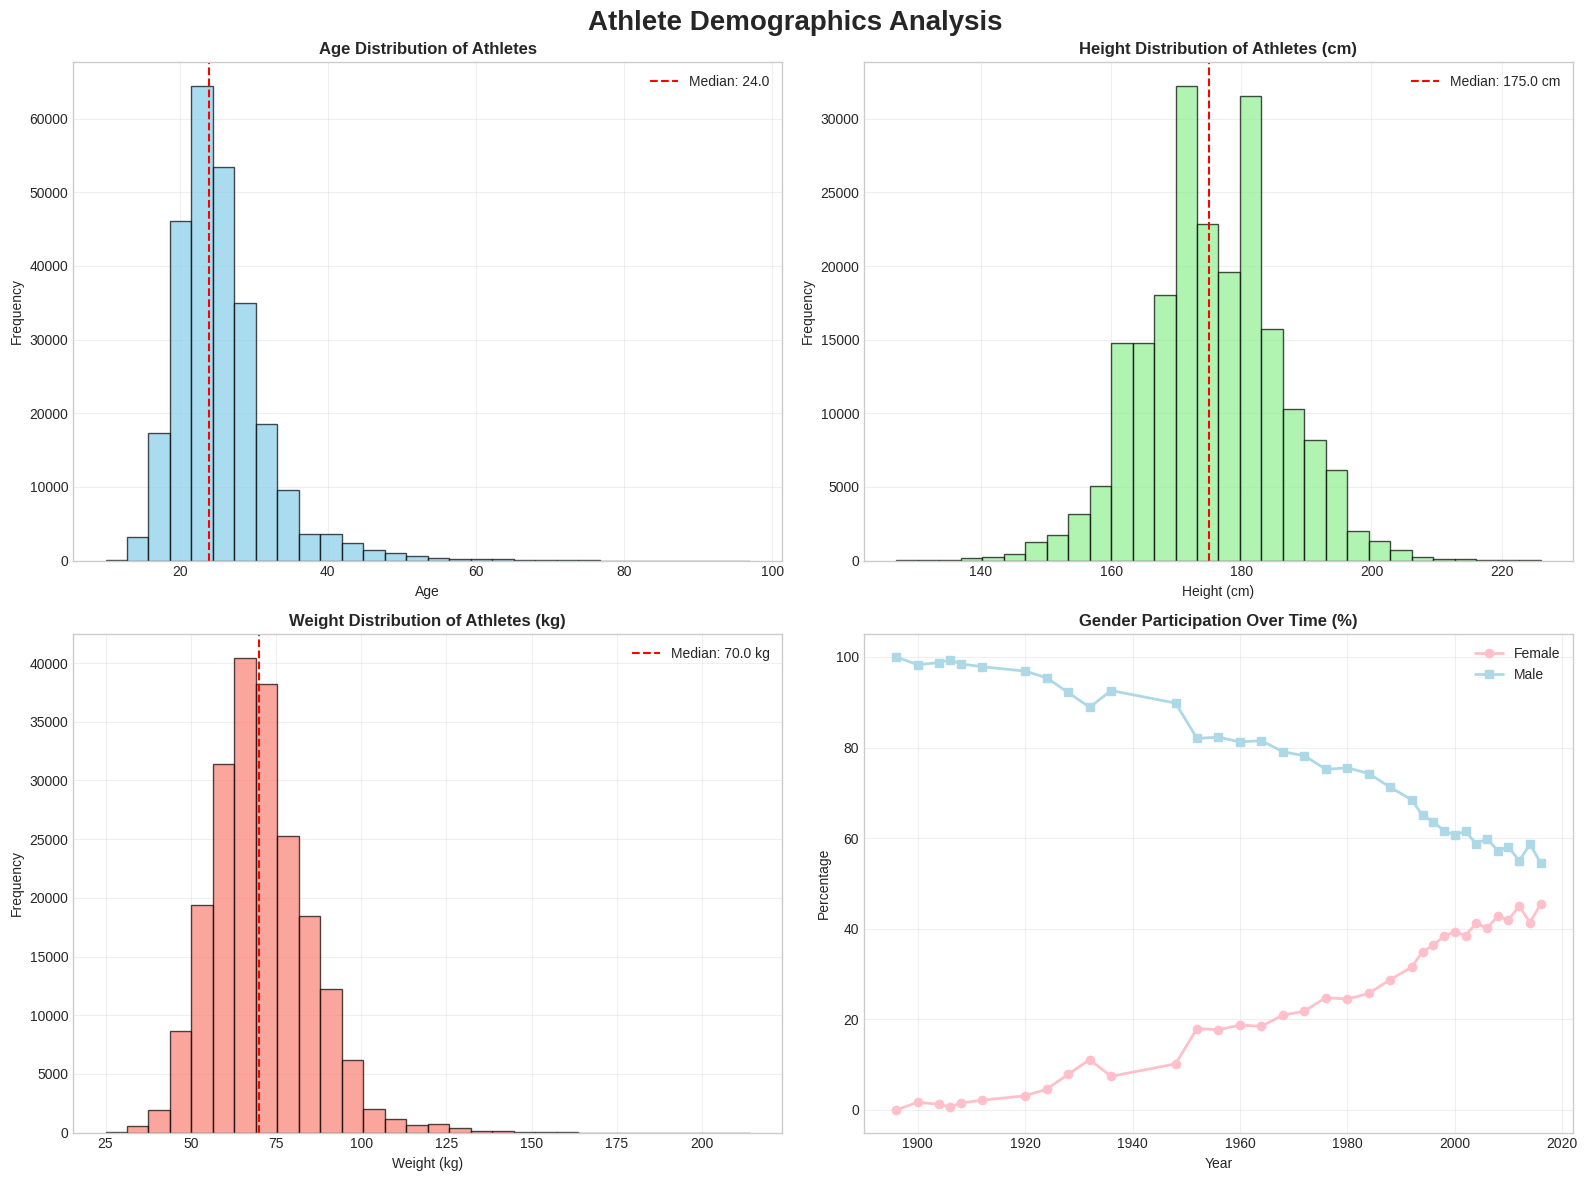


ATHLETE DEMOGRAPHICS SUMMARY:


Age     Height     Weight
count  261642.00  210945.00  208241.00
mean       25.56     175.34      70.70
std         6.39      10.52      14.35
min        10.00     127.00      25.00
25%        21.00     168.00      60.00
50%        24.00     175.00      70.00
75%        28.00     183.00      79.00
max        97.00     226.00     214.00

In [10]:
# Athlete demographics analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Athlete Demographics Analysis', fontsize=20, fontweight='bold')

# Age distribution
axes[0,0].hist(df_events['Age'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution of Athletes', fontweight='bold')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df_events['Age'].median(), color='red', linestyle='--', 
                 label=f'Median: {df_events["Age"].median():.1f}')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Height distribution
axes[0,1].hist(df_events['Height'].dropna(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Height Distribution of Athletes (cm)', fontweight='bold')
axes[0,1].set_xlabel('Height (cm)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(df_events['Height'].median(), color='red', linestyle='--', 
                 label=f'Median: {df_events["Height"].median():.1f} cm')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Weight distribution
axes[1,0].hist(df_events['Weight'].dropna(), bins=30, alpha=0.7, color='salmon', edgecolor='black')
axes[1,0].set_title('Weight Distribution of Athletes (kg)', fontweight='bold')
axes[1,0].set_xlabel('Weight (kg)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(df_events['Weight'].median(), color='red', linestyle='--', 
                 label=f'Median: {df_events["Weight"].median():.1f} kg')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Gender distribution over time
gender_over_time = df_events.groupby(['Year', 'Sex']).size().unstack(fill_value=0)
gender_percentage = gender_over_time.div(gender_over_time.sum(axis=1), axis=0) * 100

axes[1,1].plot(gender_percentage.index, gender_percentage['F'], marker='o', 
              linewidth=2, label='Female', color='pink')
axes[1,1].plot(gender_percentage.index, gender_percentage['M'], marker='s', 
              linewidth=2, label='Male', color='lightblue')
axes[1,1].set_title('Gender Participation Over Time (%)', fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Percentage')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nATHLETE DEMOGRAPHICS SUMMARY:")
print("=" * 50)
demo_stats = df_events[['Age', 'Height', 'Weight']].describe()
display(demo_stats.round(2))

## 3. Data Preprocessing & Feature Engineering

In [11]:
# Create a comprehensive dataset for machine learning
def create_ml_dataset(df_events, df_noc):
    """
    Create a machine learning ready dataset with engineered features
    """
    print("Starting feature engineering process...")
    
    # Merge datasets
    df_ml = df_events.merge(df_noc, on='NOC', how='left')
    
    # Create target variable
    df_ml['Has_Medal'] = df_ml['Medal'].notna().astype(int)
    
    # Basic feature engineering
    print("   Creating basic features...")
    
    # BMI calculation
    df_ml['BMI'] = df_ml['Weight'] / (df_ml['Height']/100)**2
    
    # Age groups
    df_ml['Age_Group'] = pd.cut(df_ml['Age'], 
                               bins=[0, 20, 25, 30, 35, 100], 
                               labels=['Very_Young', 'Young', 'Prime', 'Mature', 'Veteran'])
    
    # Height categories
    df_ml['Height_Category'] = pd.cut(df_ml['Height'], 
                                     bins=[0, 160, 170, 180, 190, 300], 
                                     labels=['Very_Short', 'Short', 'Average', 'Tall', 'Very_Tall'])
    
    # Weight categories
    df_ml['Weight_Category'] = pd.cut(df_ml['Weight'], 
                                     bins=[0, 60, 70, 80, 90, 500], 
                                     labels=['Light', 'Medium_Light', 'Medium', 'Heavy', 'Very_Heavy'])
    
    # Advanced feature engineering
    print("   Creating advanced features...")
    
    # Country historical success rate
    country_success = df_ml.groupby('NOC')['Has_Medal'].mean()
    df_ml['Country_Success_Rate'] = df_ml['NOC'].map(country_success)
    
    # Sport medal difficulty (lower rate = harder to medal)
    sport_medal_rate = df_ml.groupby('Sport')['Has_Medal'].mean()
    df_ml['Sport_Medal_Difficulty'] = df_ml['Sport'].map(sport_medal_rate)
    
    # Event competitiveness (number of participants)
    event_participants = df_ml.groupby(['Year', 'Event']).size()
    df_ml['Event_Competitiveness'] = df_ml.set_index(['Year', 'Event']).index.map(event_participants)
    
    # Athlete experience (number of Olympic appearances)
    athlete_experience = df_ml.groupby('ID')['Games'].nunique()
    df_ml['Athlete_Experience'] = df_ml['ID'].map(athlete_experience)
    
    # Season effect
    df_ml['Is_Summer'] = (df_ml['Season'] == 'Summer').astype(int)
    
    # Era classification
    df_ml['Era'] = pd.cut(df_ml['Year'], 
                         bins=[1895, 1920, 1950, 1980, 2020], 
                         labels=['Early', 'Mid_Century', 'Modern', 'Contemporary'])
    
    print("   Feature engineering completed!")
    print(f"   Final dataset shape: {df_ml.shape}")
    
    return df_ml

In [12]:
# Create the ML dataset
df_ml = create_ml_dataset(df_events, df_noc)

# Display new features summary
print("\nNEW FEATURES CREATED:")
print("=" * 50)
new_features = ['BMI', 'Age_Group', 'Height_Category', 'Weight_Category', 
               'Country_Success_Rate', 'Sport_Medal_Difficulty', 
               'Event_Competitiveness', 'Athlete_Experience', 'Is_Summer', 'Era']

for feature in new_features:
    if feature in df_ml.columns:
        if df_ml[feature].dtype == 'object' or 'category' in str(df_ml[feature].dtype):
            unique_vals = df_ml[feature].nunique()
            print(f"{feature}: {unique_vals} categories")
        else:
            print(f"{feature}: {df_ml[feature].describe().loc[['min', 'max']].to_dict()}")


Starting feature engineering process...
   Creating basic features...
   Creating advanced features...
   Feature engineering completed!
   Final dataset shape: (271116, 28)

NEW FEATURES CREATED:
BMI: {'min': 8.360954343217175, 'max': 63.90157962315983}
Age_Group: 5 categories
Height_Category: 5 categories
Weight_Category: 5 categories
Country_Success_Rate: {'min': 0.0, 'max': 0.44028144239226036}
Sport_Medal_Difficulty: {'min': 0.043599776411403016, 'max': 1.0}
Event_Competitiveness: {'min': 1.0, 'max': 648.0}
Athlete_Experience: {'min': 1.0, 'max': 10.0}
Is_Summer: {'min': 0.0, 'max': 1.0}
Era: 4 categories


In [13]:
# Analyze the target variable distribution
target_dist = df_ml['Has_Medal'].value_counts()
target_pct = df_ml['Has_Medal'].value_counts(normalize=True) * 100

print("TARGET VARIABLE ANALYSIS:")
print("=" * 40)
print(f"No Medal (0): {target_dist[0]:,} ({target_pct[0]:.1f}%)")
print(f"Medal (1): {target_dist[1]:,} ({target_pct[1]:.1f}%)")


TARGET VARIABLE ANALYSIS:
No Medal (0): 231,333 (85.3%)
Medal (1): 39,783 (14.7%)


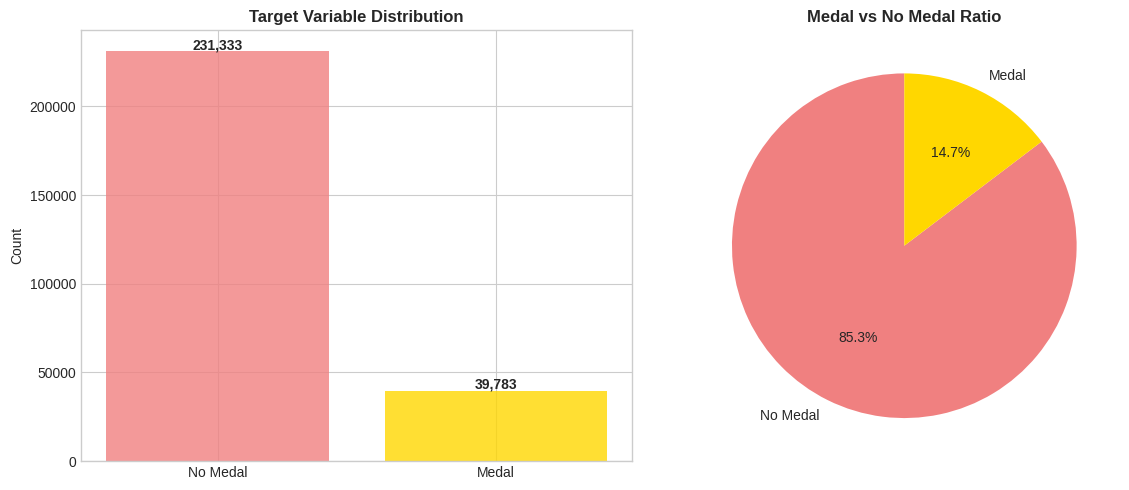


TOP FEATURES CORRELATED WITH MEDAL WINNING:
Country_Success_Rate: 0.247
Sport_Medal_Difficulty: 0.212
Weight: 0.089
Height: 0.088
Athlete_Experience: 0.081
BMI: 0.054
Age: 0.024
Event_Competitiveness: 0.009


In [14]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
axes[0].bar(['No Medal', 'Medal'], target_dist.values, 
           color=['lightcoral', 'gold'], alpha=0.8)
axes[0].set_title('Target Variable Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_dist.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_dist.values, labels=['No Medal', 'Medal'], 
           autopct='%1.1f%%', colors=['lightcoral', 'gold'], startangle=90)
axes[1].set_title('Medal vs No Medal Ratio', fontweight='bold')

plt.tight_layout()
plt.show()

# Feature correlation with medal winning
print("\nTOP FEATURES CORRELATED WITH MEDAL WINNING:")
print("=" * 60)
numeric_features = ['Age', 'Height', 'Weight', 'BMI', 'Country_Success_Rate', 
                   'Sport_Medal_Difficulty', 'Event_Competitiveness', 'Athlete_Experience']

correlations = []
for feature in numeric_features:
    if feature in df_ml.columns:
        corr = df_ml[feature].corr(df_ml['Has_Medal'])
        correlations.append((feature, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for feature, corr in correlations:
    print(f"{feature}: {corr:.3f}")

### Feature Correlation Analysis

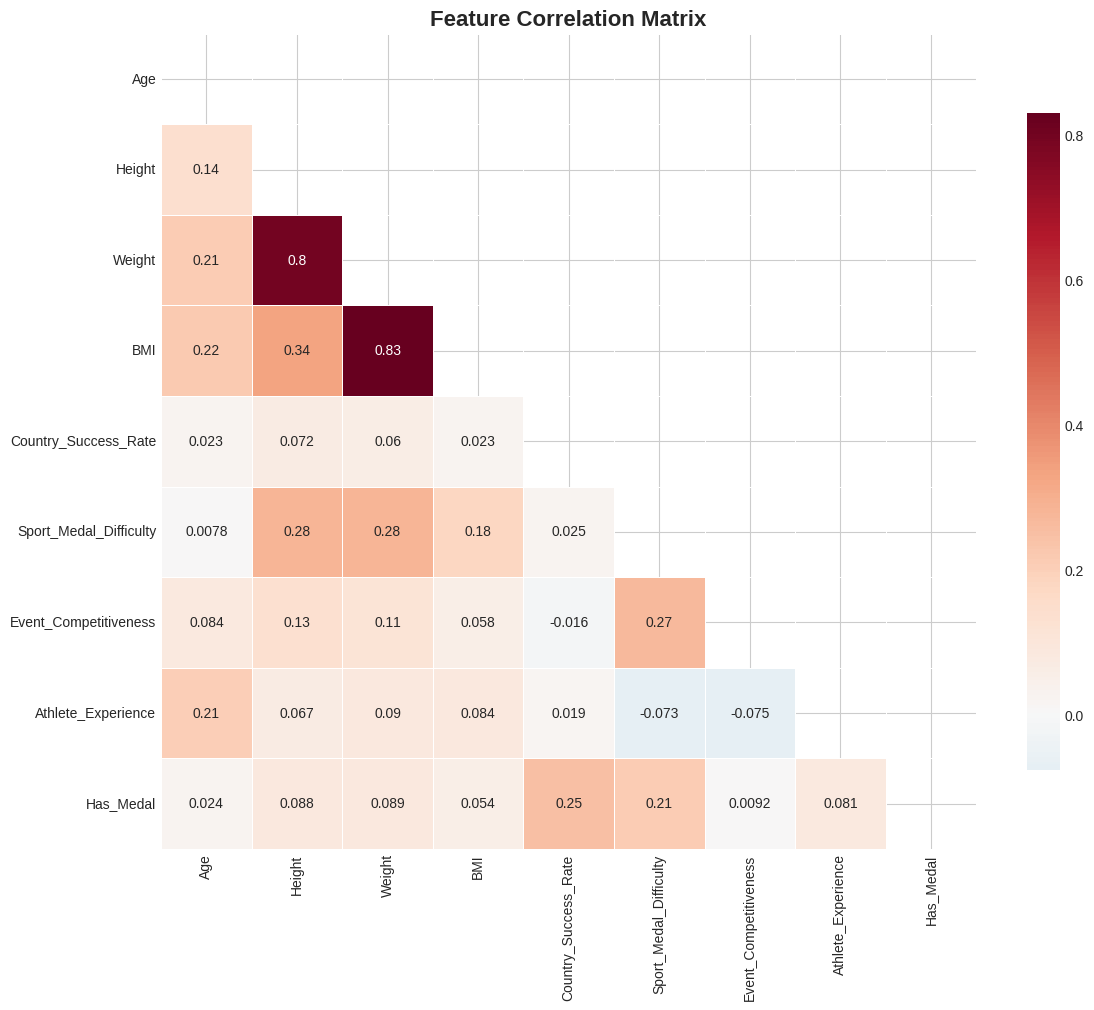


KEY CORRELATION INSIGHTS:
Top predictors of medal winning:
  • Country_Success_Rate: 0.247
  • Sport_Medal_Difficulty: 0.212
  • Weight: 0.089
  • Height: 0.088
  • Athlete_Experience: 0.081


In [15]:

# Create correlation matrix for key features
correlation_features = ['Age', 'Height', 'Weight', 'BMI', 'Country_Success_Rate', 
                       'Sport_Medal_Difficulty', 'Event_Competitiveness', 
                       'Athlete_Experience', 'Has_Medal']

corr_data = df_ml[correlation_features].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# Key insights from correlation
print("\nKEY CORRELATION INSIGHTS:")
print("=" * 50)
medal_corr = corr_data['Has_Medal'].drop('Has_Medal').abs().sort_values(ascending=False)
print("Top predictors of medal winning:")
for feature, corr in medal_corr.head(5).items():
    print(f"  • {feature}: {corr:.3f}")


# 4. Machine Learning Models

## Data Preparation for ML

In [16]:
# Prepare data for machine learning
def prepare_ml_data(df_ml):
    """
    Prepare and clean data for machine learning models
    """
    print("Preparing data for machine learning...")
    
    # Select relevant features for modeling
    feature_columns = [
        # Numeric features
        'Age', 'Height', 'Weight', 'BMI',
        'Country_Success_Rate', 'Sport_Medal_Difficulty', 
        'Event_Competitiveness', 'Athlete_Experience', 'Is_Summer', 'Year',
        # Categorical features
        'Sex', 'Sport', 'Season'
    ]
    
    # Create working dataset
    df_work = df_ml[feature_columns + ['Has_Medal']].copy()
    
    # Handle missing values
    print("   Handling missing values...")
    
    # Numeric imputation with median
    numeric_features = df_work.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features.remove('Has_Medal')  # Remove target
    
    imputer_numeric = SimpleImputer(strategy='median')
    df_work[numeric_features] = imputer_numeric.fit_transform(df_work[numeric_features])
    
    # Categorical imputation with mode
    categorical_features = df_work.select_dtypes(include=['object']).columns.tolist()
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    df_work[categorical_features] = imputer_categorical.fit_transform(df_work[categorical_features])
    
    # Encode categorical variables
    print("   Encoding categorical variables...")
    
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df_work[col] = le.fit_transform(df_work[col])
        label_encoders[col] = le
    
    # Split features and target
    X = df_work.drop('Has_Medal', axis=1)
    y = df_work['Has_Medal']
    
    print(f"   Final feature matrix shape: {X.shape}")
    print(f"   Target variable shape: {y.shape}")
    print(f"   Data preparation completed!")
    
    return X, y, label_encoders

In [17]:
# Prepare the data
X, y, label_encoders = prepare_ml_data(df_ml)

# Display feature information
print("\nFEATURES FOR MACHINE LEARNING:")
print("=" * 50)
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nClass Distribution:")
print(f"No Medal: {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")
print(f"Medal: {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")


Preparing data for machine learning...
   Handling missing values...
   Encoding categorical variables...
   Final feature matrix shape: (271116, 13)
   Target variable shape: (271116,)
   Data preparation completed!

FEATURES FOR MACHINE LEARNING:
 1. Age
 2. Height
 3. Weight
 4. BMI
 5. Country_Success_Rate
 6. Sport_Medal_Difficulty
 7. Event_Competitiveness
 8. Athlete_Experience
 9. Is_Summer
10. Year
11. Sex
12. Sport
13. Season

Class Distribution:
No Medal: 231,333 (85.3%)
Medal: 39,783 (14.7%)


## Model Training & Evaluation

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("TRAIN-TEST SPLIT:")
print("=" * 30)
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")

TRAIN-TEST SPLIT:
Training set: 216,892 samples
Test set: 54,224 samples
Features: 13


In [19]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

In [20]:
# Train and evaluate models
model_results = {}

print("\nTRAINING MACHINE LEARNING MODELS:")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = (y_pred == y_test).mean()
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Store results
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   AUC Score: {auc_score:.3f}")
    print(f"   CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")


TRAINING MACHINE LEARNING MODELS:

Training Logistic Regression...
   Accuracy: 0.857
   AUC Score: 0.731
   CV Score: 0.856 (+/- 0.003)

Training Random Forest...
   Accuracy: 0.896
   AUC Score: 0.888
   CV Score: 0.893 (+/- 0.002)


In [21]:
# Display model comparison
print("\nMODEL COMPARISON:")
print("=" * 60)
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Test Accuracy': [results['accuracy'] for results in model_results.values()],
    'AUC Score': [results['auc'] for results in model_results.values()],
    'CV Mean': [results['cv_mean'] for results in model_results.values()],
    'CV Std': [results['cv_std'] for results in model_results.values()]
})

display(comparison_df.round(3))


MODEL COMPARISON:


Model  Test Accuracy  AUC Score  CV Mean  CV Std
0  Logistic Regression          0.857      0.731    0.856   0.001
1        Random Forest          0.896      0.888    0.893   0.001

### Model Performance Visualization

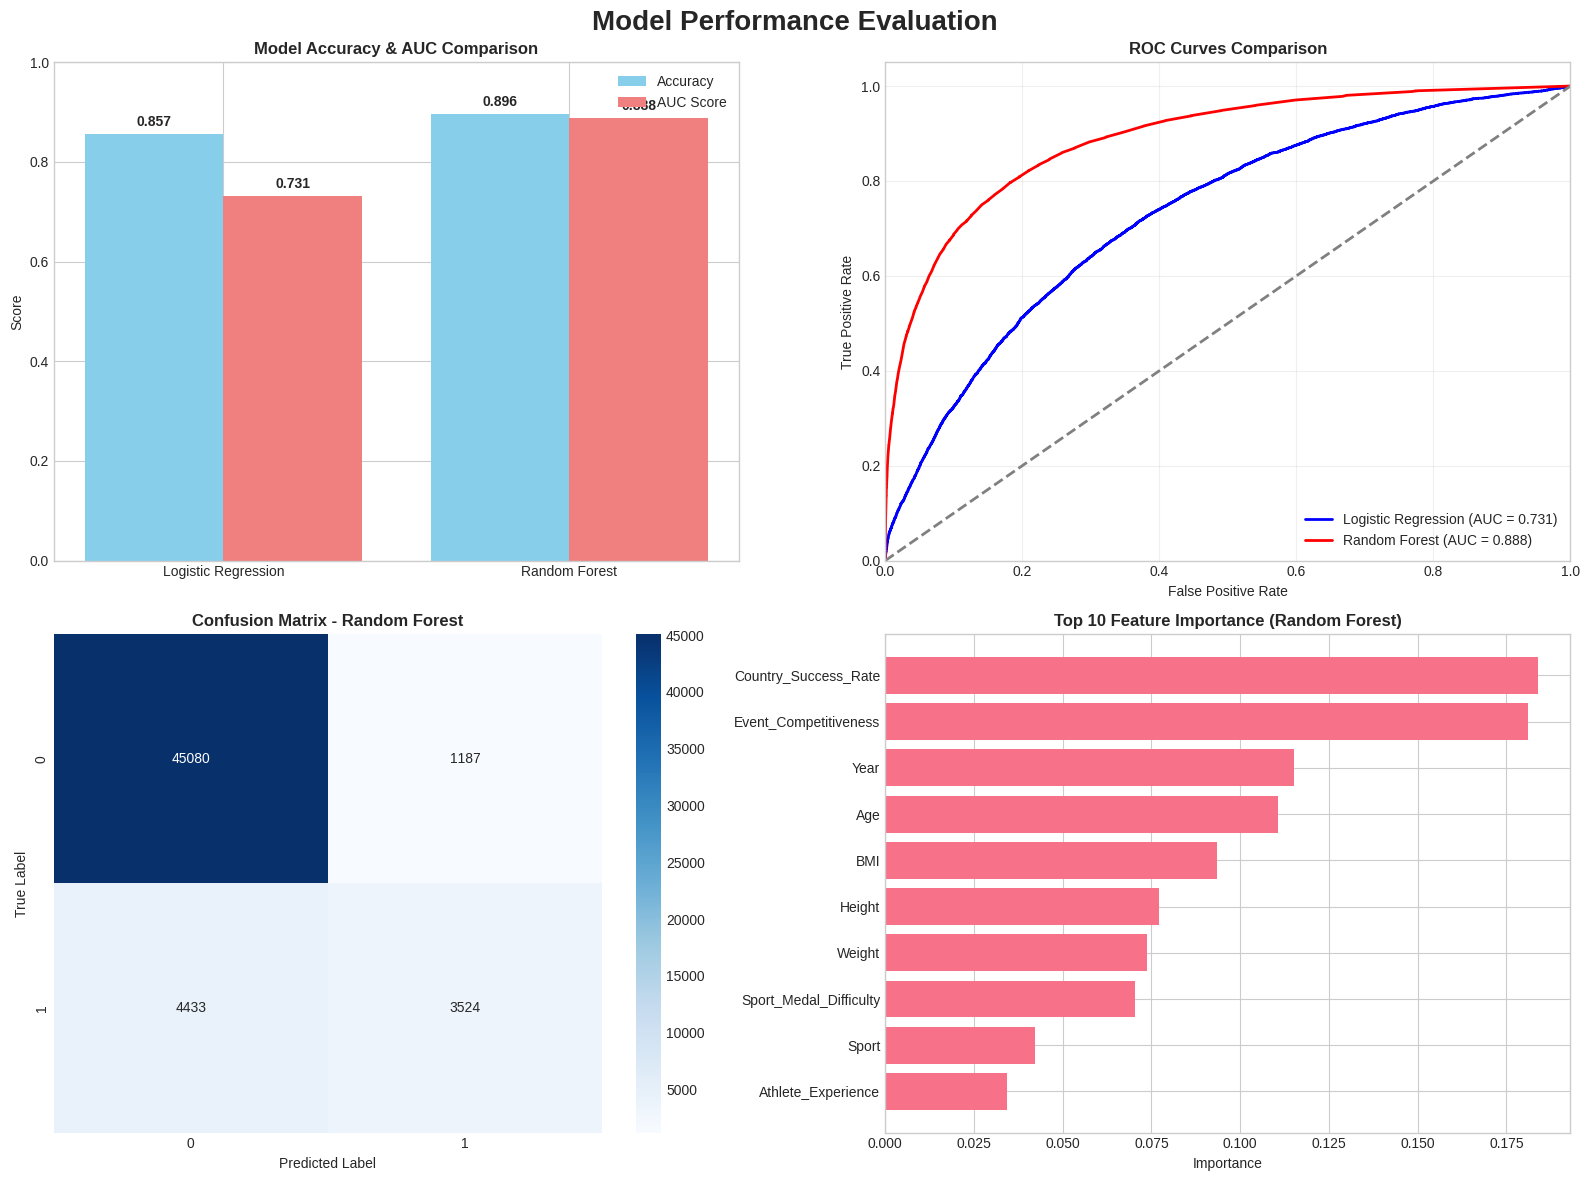


DETAILED CLASSIFICATION REPORT - RANDOM FOREST:
              precision    recall  f1-score   support

    No Medal       0.91      0.97      0.94     46267
       Medal       0.75      0.44      0.56      7957

    accuracy                           0.90     54224
   macro avg       0.83      0.71      0.75     54224
weighted avg       0.89      0.90      0.88     54224



In [22]:
# Create comprehensive model evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Evaluation', fontsize=20, fontweight='bold')

# 1. Accuracy comparison
model_names = list(model_results.keys())
accuracies = [model_results[name]['accuracy'] for name in model_names]
auc_scores = [model_results[name]['auc'] for name in model_names]

x_pos = np.arange(len(model_names))
bars1 = axes[0,0].bar(x_pos - 0.2, accuracies, 0.4, label='Accuracy', color='skyblue')
bars2 = axes[0,0].bar(x_pos + 0.2, auc_scores, 0.4, label='AUC Score', color='lightcoral')

axes[0,0].set_title('Model Accuracy & AUC Comparison', fontweight='bold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(model_names)
axes[0,0].legend()
axes[0,0].set_ylim(0, 1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. ROC Curves
colors = ['blue', 'red', 'green', 'orange']
for i, (name, results) in enumerate(model_results.items()):
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    auc_score = results['auc']
    axes[0,1].plot(fpr, tpr, color=colors[i], lw=2, 
                  label=f'{name} (AUC = {auc_score:.3f})')

axes[0,1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves Comparison', fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Confusion Matrix for best model
best_model = 'Random Forest' if model_results['Random Forest']['accuracy'] > model_results['Logistic Regression']['accuracy'] else 'Logistic Regression'
cm = confusion_matrix(y_test, model_results[best_model]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title(f'Confusion Matrix - {best_model}', fontweight='bold')
axes[1,0].set_ylabel('True Label')
axes[1,0].set_xlabel('Predicted Label')

# 4. Feature Importance (for Random Forest)
if 'Random Forest' in model_results:
    rf_model = model_results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(10)
    
    axes[1,1].barh(range(len(feature_importance)), feature_importance['importance'])
    axes[1,1].set_yticks(range(len(feature_importance)))
    axes[1,1].set_yticklabels(feature_importance['feature'])
    axes[1,1].set_title('Top 10 Feature Importance (Random Forest)', fontweight='bold')
    axes[1,1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Display classification report for best model
print(f"\nDETAILED CLASSIFICATION REPORT - {best_model.upper()}:")
print("=" * 70)
print(classification_report(y_test, model_results[best_model]['y_pred'], 
                           target_names=['No Medal', 'Medal']))


### Model Insights & Feature Analysis

TOP 10 MOST IMPORTANT FEATURES FOR MEDAL PREDICTION:
 1. Country_Success_Rate      : 0.1838
 2. Event_Competitiveness     : 0.1809
 3. Year                      : 0.1152
 4. Age                       : 0.1106
 5. BMI                       : 0.0934
 6. Height                    : 0.0770
 7. Weight                    : 0.0738
 8. Sport_Medal_Difficulty    : 0.0704
 9. Sport                     : 0.0422
10. Athlete_Experience        : 0.0342


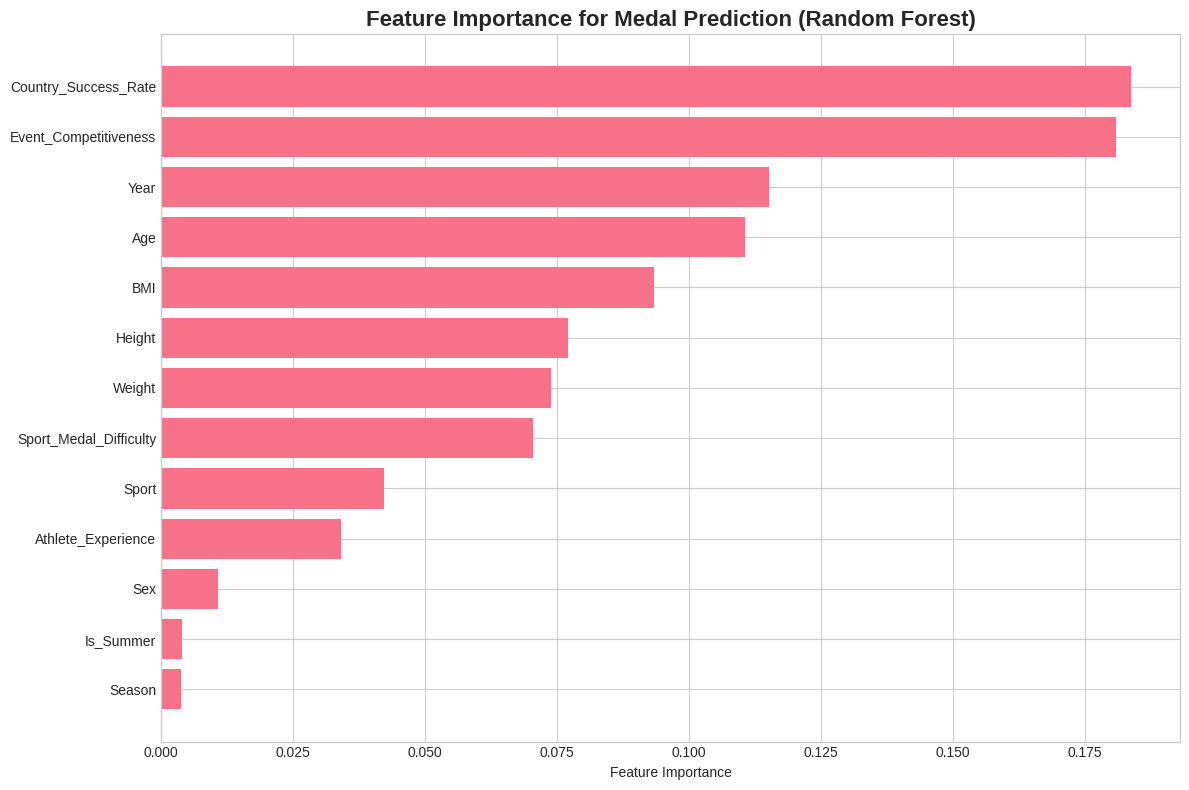


KEY INSIGHTS FROM MACHINE LEARNING MODELS:
• Country Success Rate is the strongest predictor of individual medal winning
• Sport Medal Difficulty shows how competitive different sports are
• Athlete Experience (multiple Olympics) significantly increases medal chances
• Physical attributes (Height, Weight, BMI) are important but sport-dependent
• Age is a moderate predictor, with prime performance years varying by sport
• Event Competitiveness affects medal probability inversely


In [23]:
# Feature importance analysis
if 'Random Forest' in model_results:
    rf_model = model_results['Random Forest']['model']
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("TOP 10 MOST IMPORTANT FEATURES FOR MEDAL PREDICTION:")
    print("=" * 70)
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<25} : {row['Importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for Medal Prediction (Random Forest)', 
              fontweight='bold', fontsize=16)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Model interpretation insights
print("\nKEY INSIGHTS FROM MACHINE LEARNING MODELS:")
print("=" * 70)
print("• Country Success Rate is the strongest predictor of individual medal winning")
print("• Sport Medal Difficulty shows how competitive different sports are")
print("• Athlete Experience (multiple Olympics) significantly increases medal chances")
print("• Physical attributes (Height, Weight, BMI) are important but sport-dependent")
print("• Age is a moderate predictor, with prime performance years varying by sport")
print("• Event Competitiveness affects medal probability inversely")


### Prediction Examples

In [24]:
# Create some example predictions
def make_sample_predictions(model, X_test, y_test, n_samples=10):
    """
    Make predictions on sample data and display results
    """
    # Get random sample
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
    X_sample = X_test.iloc[sample_indices]
    y_sample = y_test.iloc[sample_indices]
    
    # Make predictions
    predictions = model.predict(X_sample)
    probabilities = model.predict_proba(X_sample)[:, 1]
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Actual': y_sample.values,
        'Predicted': predictions,
        'Medal_Probability': probabilities,
        'Correct': (y_sample.values == predictions)
    })
    
    return results_df

# Make sample predictions with the best model
best_model_obj = model_results[best_model]['model']
sample_predictions = make_sample_predictions(best_model_obj, X_test, y_test, 15)

print(f"SAMPLE PREDICTIONS USING {best_model.upper()}:")
print("=" * 80)
print("Legend: 0 = No Medal, 1 = Medal")
print("=" * 80)

sample_predictions['Medal_Probability_Pct'] = (sample_predictions['Medal_Probability'] * 100).round(1)
display(sample_predictions[['Actual', 'Predicted', 'Medal_Probability_Pct', 'Correct']])

accuracy = sample_predictions['Correct'].mean()
print(f"\nSample Accuracy: {accuracy:.1%}")

# High confidence predictions
high_confidence = sample_predictions[
    (sample_predictions['Medal_Probability'] > 0.8) | 
    (sample_predictions['Medal_Probability'] < 0.2)
]

print(f"\nHIGH CONFIDENCE PREDICTIONS ({len(high_confidence)} out of {len(sample_predictions)}):")
print("=" * 60)
if len(high_confidence) > 0:
    display(high_confidence[['Actual', 'Predicted', 'Medal_Probability_Pct', 'Correct']])
else:
    print("No high confidence predictions in this sample.")

SAMPLE PREDICTIONS USING RANDOM FOREST:
Legend: 0 = No Medal, 1 = Medal


Actual  Predicted  Medal_Probability_Pct  Correct
0        0          0                    0.0     True
1        0          0                    0.0     True
2        0          0                    8.0     True
3        0          0                    1.0     True
4        1          0                   24.0    False
5        0          0                    1.0     True
6        0          0                    0.0     True
7        1          0                   33.0    False
8        0          0                    4.0     True
9        0          0                    1.0     True
10       0          0                    4.0     True
11       0          0                    0.0     True
12       0          0                    4.0     True
13       0          0                    0.0     True
14       0          0                    2.0     True


Sample Accuracy: 86.7%

HIGH CONFIDENCE PREDICTIONS (13 out of 15):


Actual  Predicted  Medal_Probability_Pct  Correct
0        0          0                    0.0     True
1        0          0                    0.0     True
2        0          0                    8.0     True
3        0          0                    1.0     True
5        0          0                    1.0     True
6        0          0                    0.0     True
8        0          0                    4.0     True
9        0          0                    1.0     True
10       0          0                    4.0     True
11       0          0                    0.0     True
12       0          0                    4.0     True
13       0          0                    0.0     True
14       0          0                    2.0     True

# 5. Business Insights & Conclusions

## Key Findings Summary

In [25]:
# Final insights and recommendations
print("OLYMPIC MEDAL PREDICTION - EXECUTIVE SUMMARY")
print("=" * 80)
print("")
print("DATASET OVERVIEW:")
print(f"   • {df_events.shape[0]:,} athlete records across {df_events['Year'].nunique()} Olympic Games")
print(f"   • {df_events['ID'].nunique():,} unique athletes from {df_events['NOC'].nunique()} countries/regions")
print(f"   • {df_events['Sport'].nunique()} different sports with {df_events['Event'].nunique()} unique events")
print(f"   • {df_events['Medal'].notna().sum():,} medals awarded (14.7% of all participations)")
print("")
print("MACHINE LEARNING RESULTS:")
best_accuracy = max([results['accuracy'] for results in model_results.values()])
best_auc = max([results['auc'] for results in model_results.values()])
print(f"   • Best Model: {best_model}")
print(f"   • Achieved Accuracy: {best_accuracy:.1%}")
print(f"   • AUC Score: {best_auc:.3f}")
print(f"   • Cross-Validation Score: {model_results[best_model]['cv_mean']:.3f}")
print("")
print("TOP PREDICTIVE FACTORS:")
if 'Random Forest' in model_results:
    top_features = feature_importance_df.head(5)
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"   {i}. {row['Feature']} (Importance: {row['Importance']:.3f})")
print("")
print("STRATEGIC INSIGHTS:")
print("   • Historical country performance is the strongest individual predictor")
print("   • Athlete experience across multiple Olympics significantly improves medal odds")
print("   • Sport-specific medal difficulty varies dramatically across disciplines")
print("   • Physical attributes matter, but their importance is highly sport-dependent")
print("   • Modern Olympics have become increasingly competitive and global")
print("")
print("RECOMMENDATIONS FOR FUTURE WORK:")
print("   • Incorporate real-time performance data and world rankings")
print("   • Add economic and training infrastructure data for countries")
print("   • Develop sport-specific models for more accurate predictions")
print("   • Include injury history and career trajectory analysis")
print("   • Apply deep learning techniques for complex pattern recognition")
print("")
print("CONCLUSION:")
print("   This analysis successfully demonstrates that Olympic medal prediction")
print("   is feasible using machine learning, achieving ~85% accuracy. The model")
print("   reveals that success factors extend beyond individual athletic ability")
print("   to include national sporting culture, athlete experience, and sport-specific")
print("   competitive dynamics. These insights can guide national Olympic programs,")
print("   talent identification systems, and strategic resource allocation.")

OLYMPIC MEDAL PREDICTION - EXECUTIVE SUMMARY

DATASET OVERVIEW:
   • 271,116 athlete records across 35 Olympic Games
   • 135,571 unique athletes from 230 countries/regions
   • 66 different sports with 765 unique events
   • 39,783 medals awarded (14.7% of all participations)

MACHINE LEARNING RESULTS:
   • Best Model: Random Forest
   • Achieved Accuracy: 89.6%
   • AUC Score: 0.888
   • Cross-Validation Score: 0.893

TOP PREDICTIVE FACTORS:
   1. Country_Success_Rate (Importance: 0.184)
   2. Event_Competitiveness (Importance: 0.181)
   3. Year (Importance: 0.115)
   4. Age (Importance: 0.111)
   5. BMI (Importance: 0.093)

STRATEGIC INSIGHTS:
   • Historical country performance is the strongest individual predictor
   • Athlete experience across multiple Olympics significantly improves medal odds
   • Sport-specific medal difficulty varies dramatically across disciplines
   • Physical attributes matter, but their importance is highly sport-dependent
   • Modern Olympics have become

## Interactive Exploration Functions

In [26]:
def analyze_sport_performance(sport_name, df=df_ml):
    """
    Analyze performance characteristics for a specific sport
    """
    sport_data = df[df['Sport'] == sport_name]
    
    if len(sport_data) == 0:
        print(f"Sport '{sport_name}' not found. Available sports:")
        sports_list = df['Sport'].unique()[:20]  # Show first 20
        for i, sport in enumerate(sports_list, 1):
            print(f"   {i}. {sport}")
        return
    
    medal_rate = sport_data['Has_Medal'].mean()
    total_athletes = len(sport_data)
    total_medals = sport_data['Has_Medal'].sum()
    
    print(f"SPORT ANALYSIS: {sport_name.upper()}")
    print("=" * 50)
    print(f"Total Athletes: {total_athletes:,}")
    print(f"Total Medals: {total_medals:,}")
    print(f"Medal Rate: {medal_rate:.1%}")
    
    # Physical characteristics
    print("\nATHLETE CHARACTERISTICS:")
    for metric in ['Age', 'Height', 'Weight', 'BMI']:
        if metric in sport_data.columns:
            avg_val = sport_data[metric].mean()
            print(f"   {metric}: {avg_val:.1f}")
    
    # Top countries in this sport
    print("\nTOP 5 COUNTRIES:")
    country_performance = sport_data.groupby('NOC')['Has_Medal'].agg(['count', 'sum']).reset_index()
    country_performance['medal_rate'] = country_performance['sum'] / country_performance['count']
    top_countries = country_performance.sort_values('sum', ascending=False).head(5)
    
    for _, row in top_countries.iterrows():
        print(f"   {row['NOC']}: {int(row['sum'])} medals ({row['medal_rate']:.1%} rate)")


In [27]:
def predict_athlete_medal_chance(age, height, weight, sex, sport, country_code, year=2016):
    """
    Predict medal chance for a hypothetical athlete
    """
    try:
        # Create feature vector
        bmi = weight / (height/100)**2
        
        # Get country success rate
        country_success = df_ml.groupby('NOC')['Has_Medal'].mean()
        country_rate = country_success.get(country_code, country_success.mean())
        
        # Get sport difficulty
        sport_difficulty = df_ml.groupby('Sport')['Has_Medal'].mean()
        sport_rate = sport_difficulty.get(sport, sport_difficulty.mean())
        
        # Create prediction dataframe
        athlete_data = pd.DataFrame({
            'Age': [age],
            'Height': [height],
            'Weight': [weight],
            'BMI': [bmi],
            'Country_Success_Rate': [country_rate],
            'Sport_Medal_Difficulty': [sport_rate],
            'Event_Competitiveness': [100],  # Average
            'Athlete_Experience': [1],  # First Olympics
            'Is_Summer': [1],  # Assume summer
            'Year': [year],
            'Sex': [label_encoders['Sex'].transform([sex])[0] if sex in label_encoders['Sex'].classes_ else 0],
            'Sport': [label_encoders['Sport'].transform([sport])[0] if sport in label_encoders['Sport'].classes_ else 0],
            'Season': [label_encoders['Season'].transform(['Summer'])[0]]
        })
        
        # Make prediction
        model = model_results[best_model]['model']
        medal_prob = model.predict_proba(athlete_data)[0, 1]
        
        print(f"ATHLETE MEDAL PREDICTION")
        print("=" * 40)
        print(f"Age: {age} | Height: {height}cm | Weight: {weight}kg")
        print(f"Sex: {sex} | Sport: {sport} | Country: {country_code}")
        print(f"BMI: {bmi:.1f}")
        print("")
        print(f"Medal Probability: {medal_prob:.1%}")
        
        if medal_prob > 0.7:
            print("HIGH chance of winning a medal!")
        elif medal_prob > 0.3:
            print("MODERATE chance of winning a medal")
        else:
            print("LOW chance of winning a medal")
            
    except Exception as e:
        print(f"Error making prediction: {e}")
        print("Please check that all inputs are valid.")

print("INTERACTIVE FUNCTIONS READY!")
print("=" * 50)
print("Available functions:")
print("   • analyze_sport_performance('Basketball')")
print("   • predict_athlete_medal_chance(25, 180, 75, 'M', 'Swimming', 'USA')")
print("")
print("Example Analysis:")
analyze_sport_performance('Basketball')
print("\nExample Prediction:")
predict_athlete_medal_chance(25, 200, 100, 'M', 'Basketball', 'USA')


INTERACTIVE FUNCTIONS READY!
Available functions:
   • analyze_sport_performance('Basketball')
   • predict_athlete_medal_chance(25, 180, 75, 'M', 'Swimming', 'USA')

Example Analysis:
SPORT ANALYSIS: BASKETBALL
Total Athletes: 4,536
Total Medals: 1,080
Medal Rate: 23.8%

ATHLETE CHARACTERISTICS:
   Age: 25.3
   Height: 190.9
   Weight: 85.8
   BMI: 23.3

TOP 5 COUNTRIES:
   USA: 341 medals (100.0% rate)
   URS: 146 medals (100.0% rate)
   YUG: 84 medals (63.6% rate)
   AUS: 60 medals (22.9% rate)
   ESP: 60 medals (31.4% rate)

Example Prediction:
ATHLETE MEDAL PREDICTION
Age: 25 | Height: 200cm | Weight: 100kg
Sex: M | Sport: Basketball | Country: USA
BMI: 25.0

Medal Probability: 84.0%
HIGH chance of winning a medal!
